In [29]:
import jdc
import random
import iplantuml

In [30]:
class UnoCard:
    COLOR_B = 0
    COLOR_R = 1
    COLOR_Y = 2
    COLOR_G = 3
    COLOR_W = 4
    COLORS = {COLOR_B:'blue', COLOR_R:'red', COLOR_Y:'yellow', COLOR_G:'green'}
    ACTION_S = 10
    ACTION_DT = 11
    ACTION_R = 12
    ACTIONS = {ACTION_S:'skip', ACTION_DT:'draw two', ACTION_R:'reverse'}
    DRAW4_Y = 20
    DRAW4_N = 21
    WILD = {DRAW4_Y: ' draw 4', DRAW4_N:''}
    def __init__(self, color, val):
        self.color = color
        self.val = val
    def __str__(self):
        print('not implemented')
    def __eq__(self, other):
        print('not implemented')

class NumberCard(UnoCard):
    def __init__(self, color, number):
        super().__init__(color, number)
    def __str__(self):
        return f'{UnoCard.COLORS[self.color]} {self.val}'
    def __eq__(self, other):
        if isinstance(other, NumberCard):
            return str(self) == str(other)
        return False
        
class ActionCard(UnoCard):
    def __init__(self, color, action):
        super().__init__(color, action)
    def __str__(self):
        return f'{UnoCard.COLORS[self.color]} {UnoCard.ACTIONS[self.val]}'
    def __eq__(self, other):
        if isinstance(other, ActionCard):
            return str(self) == str(other)
        return False

class WildCard(UnoCard):
    def __init__(self, draw4 = False):
        if draw4:
            super().__init__(UnoCard.COLOR_W, UnoCard.WILD[UnoCard.DRAW4_Y])
        else:
            super().__init__(UnoCard.COLOR_W, UnoCard.WILD[UnoCard.DRAW4_N])
    def __str__(self):
        return f'wild{self.val}'
    def __eq__(self, other):
        if isinstance(other, WildCard):
            return str(self) == str(other)
        return False

In [31]:
class Node:
    def __init__(self, card):
        self.card = card
        self.next = None

In [32]:
class Deck:
    def __init__(self):
        self.head = None
        self.tail = None
        self.count = 0
        self.discards = []
        self.populate()

In [33]:
%%add_to Deck
# append a card to deck
def append(self, card):
    node = Node(card)
    self.count += 1
    # deck empty
    if not self.head:
        self.head = self.tail = node
        return
    # deck not empty, append the new node to tail
    self.tail.next = node
    self.tail = node

In [34]:
%%add_to Deck
# populate deck with UNO cards
def populate(self):
    for c in UnoCard.COLORS:
        self.append(NumberCard(c, 0))
        for n in range(1, 10):  
            self.append(NumberCard(c, n))
            self.append(NumberCard(c, n))
        for a in UnoCard.ACTIONS:
            self.append(ActionCard(c, a))
            self.append(ActionCard(c, a))
    for _ in range(4):
        self.append(WildCard())
        self.append(WildCard(True))

In [35]:
%%add_to Deck
# shtffle the deck
def shuffle(self):
    cards = []
    curr = self.head
    # convert the linked list to list
    while curr:
        cards.append(curr.card)
        curr = curr.next
    random.shuffle(cards)
    self.head = None
    self.count = 0
    # convert shuffled deck back to linked list
    for card in cards:
        self.append(card)

In [36]:
%%add_to Deck
# deal n cards, returned as a list
def deal(self, n):
    # remove n cards from front of deck
    cards = []
    curr = self.head
    if n > self.count:
        print('!!! draw pile running out')
        for card in self.discards:
            self.append(card)
    while curr and n > 0:
        cards.append(curr.card)
        curr = curr.next
        n -= 1
        self.count -= 1
    self.head = curr
    return cards

In [37]:
%%add_to Deck
# print all cards in deck
def print_cards(self):
    curr = self.head
    while curr:
        print(curr.card)
        curr = curr.next
    print('\n')        

In [38]:
def is_card_playable(in_play, hand):
    return hand.color == in_play.color or hand.val == in_play.val or hand.color == UnoCard.COLOR_W

In [39]:
class Player:
    def __init__(self, name):
        self.name = name
        self.cards = []
        self.score = 0 # not implemented
    def __str__(self):
        return f'{self.name}'

In [40]:
%%add_to Player
# Player to pick a card to play
def choose_hand(self, in_play):
    cards = ', '.join(str(card) for card in self.cards)
    print(f'{self}\'s cards: {cards}')
    playables = []
    # Find all the playable cards
    for card in self.cards:
        if is_card_playable(in_play, card):
            playables.append(card)
    cards = ', '.join(str(card) for card in playables)
    print('  playables: ' + cards)
    card = None
    print(f'{self} choose a card to play')
    chosen = False
    retry = False
    while not chosen:
        while True:
            # select color
            choice = input(f'{UnoCard.COLOR_B}: Blue, {UnoCard.COLOR_R}: Red, {UnoCard.COLOR_Y}: Yellow, {UnoCard.COLOR_G}: Green, {UnoCard.COLOR_W}: Wild, <Enter>: No playable card: ')
            if choice == '':
                if playables:
                    print('Please choose a playable card')
                else:
                    chosen = True
                retry = True
                break
            try:
                choice = int(choice)
                assert UnoCard.COLOR_B <= choice <= UnoCard.COLOR_W
            except ValueError:
                print('Please enter an integer or press <Enter>')
                continue          
            except AssertionError:
                print('Please enter a valid choice')
                continue          
            else:
                break
        if retry:
            retry = False
            continue
        # if a wild card to be played, draw 4 or not?
        if choice == UnoCard.COLOR_W:
            draw4 = input('Draw 4? (y|Y for yes, anything else for no): ')
            if draw4 in ('y', 'Y'):
                # Draw 4 can't be played if there are other playable cards
                if len(playables) > 1:
                    print('Can\'t play wild draw4')
                    continue
                card = WildCard(True)
            else:
                card = WildCard()
        else: # Player chose to play a calor card. Need to select the number/action of the card to play. 
            while True:
                try:
                    val = int(input(f'The number on the card or {UnoCard.ACTION_S}: Skip, {UnoCard.ACTION_DT}: Draw 2, {UnoCard.ACTION_R}: Reverse: '))
                    assert 0 <= val <= UnoCard.ACTION_R
                except ValueError:
                    print('Please enter an integer')
                    continue
                except AssertionError:
                    print('Please enter a valid choice')
                    continue
                else:
                    break
            if val <= 9:
                card = NumberCard(choice, val)
            else:
                card = ActionCard(choice, val)
        while True:
            try:
                # is the card chosen playable
                assert card in playables
            except AssertionError:
                print('Please choose a playable card')
            else:
                chosen = True
            finally:
                break
    if card:
        self.cards.remove(card)
    return card

In [41]:
%%add_to Player
# Find a playable card
def find_playables(self, in_play):
    draw4 = None
    for card in self.cards:
        # looking for color/action match or wild card
        if card.color == in_play.color or card.val == in_play.val or card.val == UnoCard.WILD[UnoCard.DRAW4_N]:
            self.cards.remove(card)
            return card
        # wild draw 4 can only be played if there's no other playable card
        if card.val == UnoCard.WILD[UnoCard.DRAW4_Y]:
            # wild draw4 present
            draw4 = card
    # No other playable card. Play draw3
    if draw4:
        self.cards.remove(draw4)
        return draw4
    # No playable cards
    return None

In [42]:
%%add_to Player
# A wild card is being played. Player needs to choose a color.
def choose_color(self):
    color = None
    print(self.name + ', choose a color')
    while True:
        try:
            color = int(input(f'{UnoCard.COLOR_B}: Blue, {UnoCard.COLOR_R}: Red, {UnoCard.COLOR_Y}: Yellow, {UnoCard.COLOR_G}: Green: '))
            assert UnoCard.COLOR_B <= color <= UnoCard.COLOR_G
        except ValueError:
            print('Please enter an integer')
            continue          
        except AssertionError:
            print('Please enter a valid choice')
            continue          
        else:
            break
    return color

In [43]:
class Game:
    def __init__(self):
        self.deck = Deck()
        self.players = []
        self.deck.shuffle()
        self.log = []

In [44]:
%%add_to Game
def set_up(self):
    while True:
        # 2 - 10 players
        try:
            n = int(input('How many players:'))
            assert 1 < n < 11
        except ValueError:
            print('Please enter an integer')
        except AssertionError:
            print('2 to 10 players')
        else:
            break
    for i in range(n):
        # Player's name
        while True:
            try:
                name = input(f'Enter player {i+1}\'s name (default = Mary<n>):') or f'Mary{i+1}'
                print(name)
                assert name.replace(" ", "").isalnum() or name == ''
            except AssertionError:
                print('Alphanumerics or <Enter> please')
            else:
                break
        player = Player(name)
        # each player gets 7 cards at start
        player.cards = self.deck.deal(7)
        self.players.append(player)
        cards = ', '.join(str(card) for card in player.cards)
        self.log.append(str(player) + ' is dealt ' + cards)
    while True:
        # Flip the 1st non wild card
        in_play = self.deck.deal(1)[0]
        # Non wild found
        if in_play.color != UnoCard.COLOR_W:
            self.log.append(f'Top card flipped: ' + str(in_play))
            self.deck.discards.append(in_play)
            return
        # Wild found. Put it to bottom of deck.
        self.deck.append(in_play)
def wrap_up(self):
    cards = ', '.join([str(card) for card in self.deck.discards])
    self.log.append(f'\nDiscard pile {len(self.deck.discards)} cards: ' + cards)
    for player in self.players:
        cards = ', '.join([str(card) for card in player.cards])
        self.log.append(str(player) + '\'s remaining cards: ' + cards)

In [45]:
%%add_to Game
def play(self):
    self.set_up()
    # Flip the top card of deck to start the game
    forfeit_turn = False
    idx, step, step_manipulator = -1, 1, -1
    self.log.append('\nStarting Turns')
    print('\nGAME STARTING')
    in_play = self.deck.discards[-1]
    self.log.append(f'Top card revealed: {in_play}')
    print(f'Top card revealed: {in_play}')
    while True:
#        print(f'Card in play: {in_play}')
        idx = (idx + step + len(self.players)) % len(self.players)
        player = self.players[idx]
        # Wild draw 4/skip/draw 2 was last played.
        # Player loses a turn
        if forfeit_turn:
            if in_play.val in (UnoCard.WILD[UnoCard.DRAW4_Y], UnoCard.ACTION_DT): # wild draw 4 or color draw 2
                if in_play.val == UnoCard.ACTION_DT:
                    cards_drawn = self.deck.deal(2)
                else:
                    cards_drawn = self.deck.deal(4)
                player.cards += cards_drawn
                cards = ', '.join(str(c) for c in cards_drawn)
                self.log.append(f'{player} drew ' + cards)
                print(f'{player} drew ' + cards)
            self.log.append(f'{player} skipped a turn')
            print(f'{player} skipped a turn')
            forfeit_turn = False
            continue
        # Find a playable card
        if idx == 0: # human player
            hand = player.choose_hand(in_play)
        else: # computer
            hand = player.find_playables(in_play) # wild card may get played before number/symbol match
        if hand: # Found a playable card
            self.deck.discards.append(hand)
            self.log.append(f'{player} played {hand}')
            print(f'{player} played {hand}')
            # Dictate color if it's a wild card
            if hand.color == UnoCard.COLOR_W:
                if hand.val == UnoCard.WILD[UnoCard.DRAW4_Y]: # wild draw 4
                    # next player will skip a turn
                    forfeit_turn = True
                if idx == 0: # Prompt human player to choose a color
                    hand.color = player.choose_color()
                else: # computer choses a color
                    hand.color = random.choice(list(UnoCard.COLORS.keys()))
                self.log.append(f'  Chose color {UnoCard.COLORS[hand.color]}')
                print(f'  Chose color {UnoCard.COLORS[hand.color]}')
            elif hand.val in (UnoCard.ACTION_S, UnoCard.ACTION_DT): # skip or draw 2
                # next player will lose a turn
                forfeit_turn = True
            elif hand.val == UnoCard.ACTION_R:
                # Reverse was played. Change rotation
                step *= step_manipulator
            in_play = hand
        else: # playable card not found
            # Draw a card
            hand = self.deck.deal(1)[0]
            self.log.append(f'{player} drew {hand}')
            print(f'{player} drew {hand}')
            # Drew a wile card
            if hand.color == UnoCard.COLOR_W:
                self.deck.discards.append(hand)
                if hand.val == UnoCard.WILD[UnoCard.DRAW4_Y]: # wild draw 4
                    # next player will skip a turn
                    forfeit_turn = True
                # Dictate color
                if idx == 0:
                    hand.color = player.choose_color()
                else:
                    hand.color = random.choice(list(UnoCard.COLORS.keys()))
                self.log.append(f'  Played {hand}')
                print(f'  Played {hand}')
                self.log.append(f'  Chose color {UnoCard.COLORS[hand.color]}')
                print(f'  Chose color {UnoCard.COLORS[hand.color]}')
                in_play = hand
                continue
            # Drew a color card. Play it right away
            if hand.color == in_play.color or hand.val == in_play.val:
                print(f'  Played {hand}')
                self.log.append(f'  Played {hand}')
                self.deck.discards.append(hand)
                in_play = hand
                if hand.val in (UnoCard.ACTION_S, UnoCard.ACTION_DT): # skip or draw 2
                    # next player will skip a turn
                    forfeit_turn = True
                elif hand.val == UnoCard.ACTION_R:
                    step *= step_manipulator
                continue
            # Card drawn is not playable
            player.cards.append(hand)
        # Player has no cards left. Winner found
        if not player.cards:
#            won = True
            self.log.append(f'{player} WON!')
            print(f'{player} WON!')
            break
    self.wrap_up()

In [46]:
%%add_to Game
def print_log(self):
    print('\n'.join(game.log))

In [47]:
#### game = Game()
game.play()

How many players: 3
Enter player 1's name (default = Mary<n>): 


Mary1


Enter player 2's name (default = Mary<n>): 


Mary2


Enter player 3's name (default = Mary<n>): 


Mary3

GAME STARTING
Top card revealed: blue 2
Mary1's cards: wild draw 4, yellow 7, yellow 2, blue 6, green 7, green 9, blue 4
  playables: wild draw 4, yellow 2, blue 6, blue 4
Mary1 choose a card to play


0: Blue, 1: Red, 2: Yellow, 3: Green, 4: Wild, <Enter>: No playable card:  0
The number on the card or 10: Skip, 11: Draw 2, 12: Reverse:  4


Mary1 played blue 4
Mary2 played blue 3
Mary3 played blue 4
Mary1's cards: wild draw 4, yellow 7, yellow 2, blue 6, green 7, green 9
  playables: wild draw 4, blue 6
Mary1 choose a card to play


0: Blue, 1: Red, 2: Yellow, 3: Green, 4: Wild, <Enter>: No playable card:  0
The number on the card or 10: Skip, 11: Draw 2, 12: Reverse:  6


Mary1 played blue 6
Mary2 played blue 6
Mary3 played blue 9
Mary1's cards: wild draw 4, yellow 7, yellow 2, green 7, green 9
  playables: wild draw 4, green 9
Mary1 choose a card to play


0: Blue, 1: Red, 2: Yellow, 3: Green, 4: Wild, <Enter>: No playable card:  3
The number on the card or 10: Skip, 11: Draw 2, 12: Reverse:  9


Mary1 played green 9
Mary2 drew green 1
  Played green 1
Mary3 played green 1
Mary1's cards: wild draw 4, yellow 7, yellow 2, green 7
  playables: wild draw 4, green 7
Mary1 choose a card to play


0: Blue, 1: Red, 2: Yellow, 3: Green, 4: Wild, <Enter>: No playable card:  3
The number on the card or 10: Skip, 11: Draw 2, 12: Reverse:  7


Mary1 played green 7
Mary2 played blue 7
Mary3 played wild draw 4
  Chose color red
Mary1 drew blue reverse, red 7, red 4, red skip
Mary1 skipped a turn
Mary2 played red 0
Mary3 played red 8
Mary1's cards: wild draw 4, yellow 7, yellow 2, blue reverse, red 7, red 4, red skip
  playables: wild draw 4, red 7, red 4, red skip
Mary1 choose a card to play


0: Blue, 1: Red, 2: Yellow, 3: Green, 4: Wild, <Enter>: No playable card:  1
The number on the card or 10: Skip, 11: Draw 2, 12: Reverse:  7


Mary1 played red 7
Mary2 played red 6
Mary3 drew yellow 2
Mary1's cards: wild draw 4, yellow 7, yellow 2, blue reverse, red 4, red skip
  playables: wild draw 4, red 4, red skip
Mary1 choose a card to play


0: Blue, 1: Red, 2: Yellow, 3: Green, 4: Wild, <Enter>: No playable card:  2
The number on the card or 10: Skip, 11: Draw 2, 12: Reverse:  4


Please choose a playable card


0: Blue, 1: Red, 2: Yellow, 3: Green, 4: Wild, <Enter>: No playable card:  1
The number on the card or 10: Skip, 11: Draw 2, 12: Reverse:  4


Mary1 played red 4
Mary2 played red 5
Mary3 drew red 5
  Played red 5
Mary1's cards: wild draw 4, yellow 7, yellow 2, blue reverse, red skip
  playables: wild draw 4, red skip
Mary1 choose a card to play


0: Blue, 1: Red, 2: Yellow, 3: Green, 4: Wild, <Enter>: No playable card:  1
The number on the card or 10: Skip, 11: Draw 2, 12: Reverse:  10


Mary1 played red skip
Mary2 skipped a turn
Mary3 drew green draw two
Mary1's cards: wild draw 4, yellow 7, yellow 2, blue reverse
  playables: wild draw 4
Mary1 choose a card to play


0: Blue, 1: Red, 2: Yellow, 3: Green, 4: Wild, <Enter>: No playable card:  4
Draw 4? (y|Y for yes, anything else for no):  y


Mary1 played wild draw 4
Mary1, choose a color


0: Blue, 1: Red, 2: Yellow, 3: Green:  2


  Chose color yellow
Mary2 drew red 6, red 1, yellow 4, green skip
Mary2 skipped a turn
Mary3 played yellow 9
Mary1's cards: yellow 7, yellow 2, blue reverse
  playables: yellow 7, yellow 2
Mary1 choose a card to play


0: Blue, 1: Red, 2: Yellow, 3: Green, 4: Wild, <Enter>: No playable card:  2
The number on the card or 10: Skip, 11: Draw 2, 12: Reverse:  7


Mary1 played yellow 7
Mary2 played yellow draw two
Mary3 drew red 4, green 4
Mary3 skipped a turn
Mary1's cards: yellow 2, blue reverse
  playables: yellow 2
Mary1 choose a card to play


0: Blue, 1: Red, 2: Yellow, 3: Green, 4: Wild, <Enter>: No playable card:  2
The number on the card or 10: Skip, 11: Draw 2, 12: Reverse:  2


Mary1 played yellow 2
Mary2 played yellow 4
Mary3 played yellow draw two
Mary1 drew yellow 9, green reverse
Mary1 skipped a turn
Mary2 drew yellow reverse
  Played yellow reverse
Mary1's cards: blue reverse, yellow 9, green reverse
  playables: blue reverse, yellow 9, green reverse
Mary1 choose a card to play


0: Blue, 1: Red, 2: Yellow, 3: Green, 4: Wild, <Enter>: No playable card:  2
The number on the card or 10: Skip, 11: Draw 2, 12: Reverse:  9


Mary1 played yellow 9
Mary3 played yellow 2
Mary2 drew blue skip
Mary1's cards: blue reverse, green reverse
  playables: 
Mary1 choose a card to play


0: Blue, 1: Red, 2: Yellow, 3: Green, 4: Wild, <Enter>: No playable card:  


Mary1 drew blue 8
Mary3 drew red 7
Mary2 drew blue 5
Mary1's cards: blue reverse, green reverse, blue 8
  playables: 
Mary1 choose a card to play


0: Blue, 1: Red, 2: Yellow, 3: Green, 4: Wild, <Enter>: No playable card:  


Mary1 drew yellow 8
  Played yellow 8
Mary3 drew yellow reverse
  Played yellow reverse
Mary1's cards: blue reverse, green reverse, blue 8
  playables: blue reverse, green reverse
Mary1 choose a card to play


0: Blue, 1: Red, 2: Yellow, 3: Green, 4: Wild, <Enter>: No playable card:  0
The number on the card or 10: Skip, 11: Draw 2, 12: Reverse:  12


Mary1 played blue reverse
Mary3 drew yellow 3
Mary2 played blue skip
Mary1 skipped a turn
Mary3 drew wild
  Played wild
  Chose color red
Mary2 played red 6
Mary1's cards: green reverse, blue 8
  playables: 
Mary1 choose a card to play


0: Blue, 1: Red, 2: Yellow, 3: Green, 4: Wild, <Enter>: No playable card:  


Mary1 drew green 6
  Played green 6
Mary3 played green draw two
Mary2 drew blue skip, blue 1
Mary2 skipped a turn
Mary1's cards: green reverse, blue 8
  playables: green reverse
Mary1 choose a card to play


0: Blue, 1: Red, 2: Yellow, 3: Green, 4: Wild, <Enter>: No playable card:  3
The number on the card or 10: Skip, 11: Draw 2, 12: Reverse:  12


Mary1 played green reverse
Mary2 played green skip
Mary3 skipped a turn
Mary1's cards: blue 8
  playables: 
Mary1 choose a card to play


0: Blue, 1: Red, 2: Yellow, 3: Green, 4: Wild, <Enter>: No playable card:  


Mary1 drew green 5
  Played green 5
Mary2 played blue 5
Mary3 drew green 9
Mary1's cards: blue 8
  playables: blue 8
Mary1 choose a card to play


0: Blue, 1: Red, 2: Yellow, 3: Green, 4: Wild, <Enter>: No playable card:  0
The number on the card or 10: Skip, 11: Draw 2, 12: Reverse:  8


Mary1 played blue 8
Mary1 WON!


In [50]:
game.print_log()

Mary1 is dealt wild draw 4, yellow 7, yellow 2, blue 6, green 7, green 9, blue 4
Mary2 is dealt blue 3, blue 6, red 0, blue 7, yellow draw two, red 6, red 5
Mary3 is dealt wild draw 4, yellow 9, blue 4, blue 9, green 1, yellow draw two, red 8
Top card flipped: blue 2

Starting Turns
Top card revealed: blue 2
Mary1 played blue 4
Mary2 played blue 3
Mary3 played blue 4
Mary1 played blue 6
Mary2 played blue 6
Mary3 played blue 9
Mary1 played green 9
Mary2 drew green 1
  Played green 1
Mary3 played green 1
Mary1 played green 7
Mary2 played blue 7
Mary3 played wild draw 4
  Chose color red
Mary1 drew blue reverse, red 7, red 4, red skip
Mary1 skipped a turn
Mary2 played red 0
Mary3 played red 8
Mary1 played red 7
Mary2 played red 6
Mary3 drew yellow 2
Mary1 played red 4
Mary2 played red 5
Mary3 drew red 5
  Played red 5
Mary1 played red skip
Mary2 skipped a turn
Mary3 drew green draw two
Mary1 played wild draw 4
  Chose color yellow
Mary2 drew red 6, red 1, yellow 4, green skip
Mary2 skippe

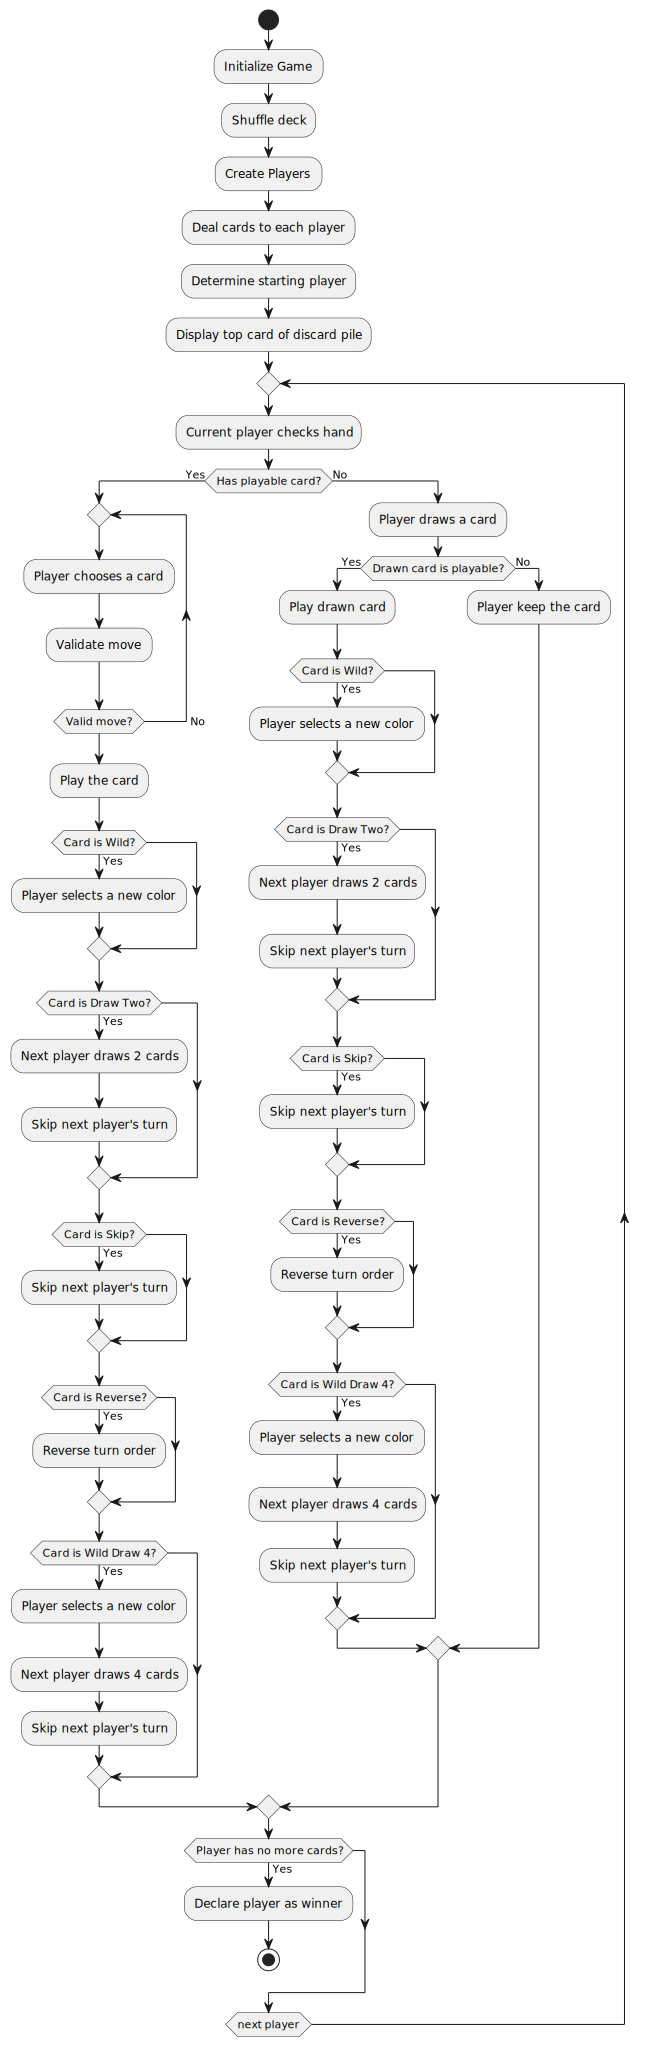

In [51]:
%%plantuml
@startuml
start

:Initialize Game;
:Shuffle deck;
:Create Players;
:Deal cards to each player;
:Determine starting player;
:Display top card of discard pile;

repeat
  :Current player checks hand;
  if (Has playable card?) then (Yes)
    repeat
    :Player chooses a card;
    :Validate move;
    repeat while (Valid move?) -> No

    :Play the card;
    
    if (Card is Wild?) then (Yes)
      :Player selects a new color;
    endif
    
    if (Card is Draw Two?) then (Yes)
      :Next player draws 2 cards;
      :Skip next player's turn;
    endif

    if (Card is Skip?) then (Yes)
      :Skip next player's turn;
    endif

    if (Card is Reverse?) then (Yes)
      :Reverse turn order;
    endif

    if (Card is Wild Draw 4?) then (Yes)
      :Player selects a new color;
      :Next player draws 4 cards;
      :Skip next player's turn;
    endif
  else (No)
    :Player draws a card;
    if (Drawn card is playable?) then (Yes)
      :Play drawn card;
    
      if (Card is Wild?) then (Yes)
        :Player selects a new color;
      endif
    
      if (Card is Draw Two?) then (Yes)
        :Next player draws 2 cards;
        :Skip next player's turn;
      endif

      if (Card is Skip?) then (Yes)
        :Skip next player's turn;
      endif

      if (Card is Reverse?) then (Yes)
        :Reverse turn order;
      endif

      if (Card is Wild Draw 4?) then (Yes)
        :Player selects a new color;
        :Next player draws 4 cards;
        :Skip next player's turn;
      endif
    else (No)
      :Player keep the card;
    endif
  endif
    
  if (Player has no more cards?) then (Yes)
    :Declare player as winner;
    stop
  endif

repeat while (next player)

@enduml
